In [1]:
!git clone https://github.com/SyedMa3/eva-template.git
%cd eva-template/

Cloning into 'eva-template'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 119 (delta 55), reused 97 (delta 33), pack-reused 0
Receiving objects: 100% (119/119), 20.67 KiB | 10.34 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/eva-template


In [2]:
!pip install torch_lr_finder -q
!pip install -U albumentations -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 KB 2.9 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [4]:
from models.model9 import CustomTransformer
from main import fit_model

In [5]:
class AlbumentationImageDataset(Dataset):
  def __init__(self, image_list, train= True):
      self.image_list = image_list
      self.aug = A.Compose(
                [
                    # A.OneOf([
                      A.Sequential([
                          A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),  # padding of 4 on each side of 32x32 image
                          A.RandomCrop(height=32, width=32, always_apply=True),
                          A.CoarseDropout(max_height=8, max_width=8, min_height=8, min_width=8, min_holes=1, max_holes=1, fill_value=(0.49139968, 0.48215841, 0.44653091), always_apply=True),
                      ], p=1),
                        # A.Sequential([
                        # ], p=1)
                    # ], p=1),  # Always apply at least one of the above transformations.
                    A.HorizontalFlip(),
                    A.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784), always_apply=True),
                ]
            )

      self.norm = A.Compose({A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784), always_apply=True),
      })
      self.train = train
        
  def __len__(self):
      return (len(self.image_list))

  def __getitem__(self, i):
      
      image, label = self.image_list[i]
      
      if self.train:
        #apply augmentation only for training
        image = self.aug(image=np.array(image))['image']
      else:
        image = self.norm(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return torch.tensor(image, dtype=torch.float), label

In [6]:
SEED = 69

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=512

CUDA Available: True


In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = CustomTransformer().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
       BatchNorm2d-2           [-1, 16, 30, 30]              32
              ReLU-3           [-1, 16, 30, 30]               0
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
       BatchNorm2d-6           [-1, 32, 28, 28]              64
              ReLU-7           [-1, 32, 28, 28]               0
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 48, 26, 26]          13,872
      BatchNorm2d-10           [-1, 48, 26, 26]              96
             ReLU-11           [-1, 48, 26, 26]               0
          Dropout-12           [-1, 48, 26, 26]               0
AdaptiveAvgPool2d-13             [-1, 48, 1, 1]               0
           Linear-14              

In [9]:
from torch_lr_finder import LRFinder


def find_lr(net, optimizer, criterion, train_loader, device):
    """Find learning rate for using One Cyclic LRFinder
    Args:
        net (instace): torch instace of defined model
        optimizer (instance): optimizer to be used
        criterion (instance): criterion to be used for calculating loss
        train_loader (instance): torch dataloader instace for trainig set
    """
    lr_finder = LRFinder(net, optimizer, criterion, device)
    lr_finder.range_test(train_loader, end_lr=0.001, num_iter=200, step_mode="exp")
    lr_finder.plot()
    lr_finder.reset()
    min_loss = min(lr_finder.history['loss'])
    ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
    print(f'Max LR is {ler_rate}')

    return ler_rate

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.77E-04


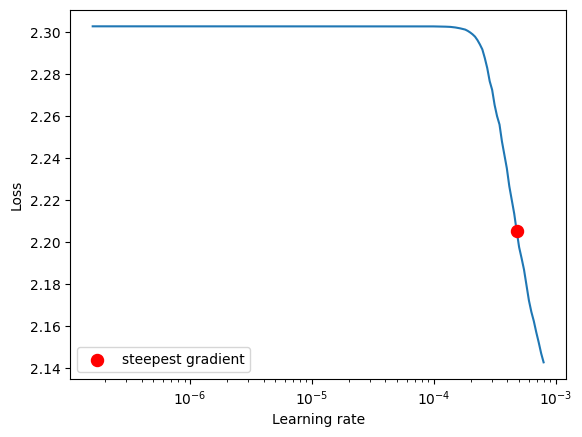

Max LR is 0.001


In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()
ler_rate = find_lr(net, optimizer, criterion, train_loader, device)

In [11]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=(5/24),
                                                div_factor=100,
                                                three_phase=False, 
                                                final_div_factor=1000,
                                                anneal_strategy='linear'
                                                )

net, history = fit_model(
    net=net,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    NUM_EPOCHS=24,
    train_loader=train_loader,
    test_loader=test_loader,
    scheduler=scheduler
)

EPOCH: 1 (LR: 1e-05)


Batch_id=97 Loss=2.29396 Accuracy=14.97:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 2.1600, Accuracy: 1672/10000 (16.72%)

EPOCH: 2 (LR: 0.00020840490797546012)


Batch_id=97 Loss=2.02446 Accuracy=18.39:   0%|          | 0/98 [00:15<?, ?it/s]



Test set: Average loss: 1.9402, Accuracy: 1879/10000 (18.79%)

EPOCH: 3 (LR: 0.0004068098159509203)


Batch_id=97 Loss=1.91447 Accuracy=20.36:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.8610, Accuracy: 2305/10000 (23.05%)

EPOCH: 4 (LR: 0.0006052147239263804)


Batch_id=97 Loss=1.88966 Accuracy=22.01:   0%|          | 0/98 [00:17<?, ?it/s]



Test set: Average loss: 1.9760, Accuracy: 2055/10000 (20.55%)

EPOCH: 5 (LR: 0.0008036196319018405)


Batch_id=97 Loss=1.86934 Accuracy=22.76:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.8328, Accuracy: 2373/10000 (23.73%)

EPOCH: 6 (LR: 0.000999462948442535)


Batch_id=97 Loss=1.83805 Accuracy=25.34:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.8528, Accuracy: 2633/10000 (26.33%)

EPOCH: 7 (LR: 0.000946831895810956)


Batch_id=97 Loss=1.80958 Accuracy=26.74:   0%|          | 0/98 [00:15<?, ?it/s]



Test set: Average loss: 1.7561, Accuracy: 2736/10000 (27.36%)

EPOCH: 8 (LR: 0.0008942008431793771)


Batch_id=97 Loss=1.78304 Accuracy=28.51:   0%|          | 0/98 [00:17<?, ?it/s]



Test set: Average loss: 1.8223, Accuracy: 2764/10000 (27.64%)

EPOCH: 9 (LR: 0.0008415697905477981)


Batch_id=97 Loss=1.76323 Accuracy=29.29:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 2.2814, Accuracy: 2304/10000 (23.04%)

EPOCH: 10 (LR: 0.0007889387379162191)


Batch_id=97 Loss=1.75454 Accuracy=29.95:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.7802, Accuracy: 2958/10000 (29.58%)

EPOCH: 11 (LR: 0.0007363076852846401)


Batch_id=97 Loss=1.73007 Accuracy=31.53:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.7080, Accuracy: 3203/10000 (32.03%)

EPOCH: 12 (LR: 0.0006836766326530613)


Batch_id=97 Loss=1.71815 Accuracy=32.01:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.9589, Accuracy: 2517/10000 (25.17%)

EPOCH: 13 (LR: 0.0006310455800214822)


Batch_id=97 Loss=1.70841 Accuracy=32.65:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.6931, Accuracy: 3477/10000 (34.77%)

EPOCH: 14 (LR: 0.0005784145273899033)


Batch_id=97 Loss=1.69499 Accuracy=33.16:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.6915, Accuracy: 3383/10000 (33.83%)

EPOCH: 15 (LR: 0.0005257834747583244)


Batch_id=97 Loss=1.68437 Accuracy=33.63:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.7140, Accuracy: 3313/10000 (33.13%)

EPOCH: 16 (LR: 0.00047315242212674536)


Batch_id=97 Loss=1.67383 Accuracy=33.79:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.6594, Accuracy: 3547/10000 (35.47%)

EPOCH: 17 (LR: 0.00042052136949516654)


Batch_id=97 Loss=1.66653 Accuracy=33.91:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.7531, Accuracy: 3343/10000 (33.43%)

EPOCH: 18 (LR: 0.0003678903168635875)


Batch_id=97 Loss=1.65664 Accuracy=34.46:   0%|          | 0/98 [00:17<?, ?it/s]



Test set: Average loss: 1.6984, Accuracy: 3471/10000 (34.71%)

EPOCH: 19 (LR: 0.0003152592642320085)


Batch_id=97 Loss=1.65714 Accuracy=34.19:   0%|          | 0/98 [00:17<?, ?it/s]



Test set: Average loss: 1.6428, Accuracy: 3524/10000 (35.24%)

EPOCH: 20 (LR: 0.00026262821160042966)


Batch_id=97 Loss=1.64964 Accuracy=34.70:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.6451, Accuracy: 3579/10000 (35.79%)

EPOCH: 21 (LR: 0.00020999715896885063)


Batch_id=97 Loss=1.63956 Accuracy=34.91:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.6158, Accuracy: 3655/10000 (36.55%)

EPOCH: 22 (LR: 0.0001573661063372717)


Batch_id=97 Loss=1.63892 Accuracy=35.17:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.6072, Accuracy: 3728/10000 (37.28%)

EPOCH: 23 (LR: 0.00010473505370569268)


Batch_id=97 Loss=1.63002 Accuracy=35.44:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.6137, Accuracy: 3634/10000 (36.34%)

EPOCH: 24 (LR: 5.210400107411386e-05)


Batch_id=97 Loss=1.62511 Accuracy=35.79:   0%|          | 0/98 [00:16<?, ?it/s]



Test set: Average loss: 1.6137, Accuracy: 3655/10000 (36.55%)



Text(0.5, 1.0, 'Test Accuracy')

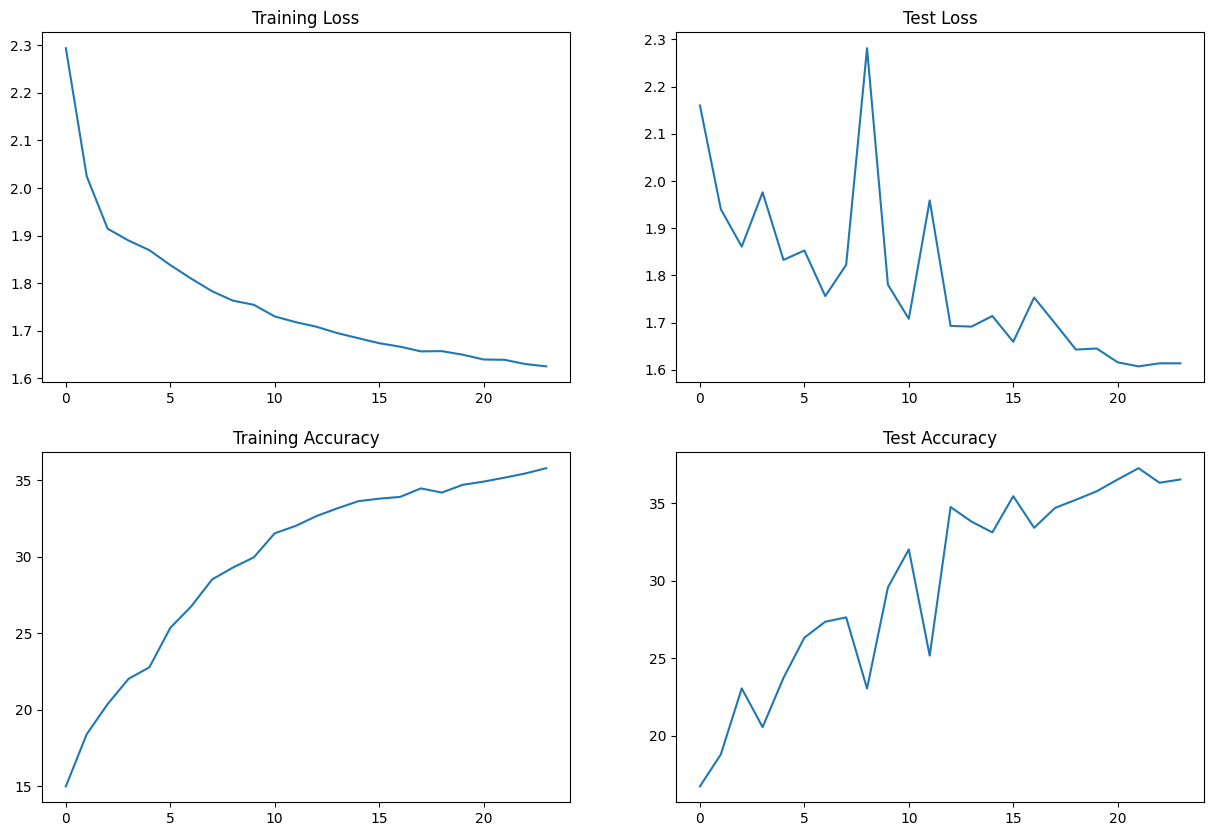

In [19]:
train_acc, train_losses, test_acc, test_losses, _ = history

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")